In [1]:
import sys
sys.path.insert(0, "/cndd/fangming/CEMBA/snmcseq_dev")

from multiprocessing import Pool,cpu_count
from functools import partial

from scipy import sparse
from scipy import stats
import importlib
from __init__ import *
from __init__jupyterlab import *
import snmcseq_utils
importlib.reload(snmcseq_utils)

import pickle
import datetime
from scipy import optimize
import re
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans
import logomaker

In [2]:
def simplify_motif_name(name):
    """
    """
#     new_name = name.split('/')[0]
    new_name = name.split('(')[0]
    return new_name

def simplify_enhclst_name(name):
    """
    """
    if name.startswith('clst'):
        name = name[4:]
    new_name = name.split('_')[0]
    return new_name

def p2f(text):
    """Convert percentage to float 
    """
    return np.float(text.strip('%'))/100

# Load data 

In [3]:
# all motif pwms
# TODO: groupby all motif clusters 
f_pattern = "/cndd2/fangming/software/homer/motifs/*.motif"
files = np.sort(glob.glob(f_pattern))

motif_pwms = {}
for file in files:
    df = pd.read_csv(file, sep='\t', skiprows=1, header=None)
    df.columns = ['A', 'C', 'G', 'T']
    
    with open(file, 'r') as fh:
        header = fh.readline()
        name = header.split('\t')[1]
        simp_name = simplify_motif_name(name) 
    
    if simp_name not in motif_pwms.keys():
        motif_pwms[simp_name] = df

all_motifs = np.sort(list(motif_pwms.keys()))
print(len(all_motifs))    
df.head() 

418


,A,C,G,T
0,0.092,0.351,0.370,0.187
1,0.302,0.419,0.143,0.135
2,0.183,0.395,0.219,0.204
3,0.574,0.032,0.215,0.179
4,0.167,0.032,0.785,0.016


In [4]:
# HOMER all motif enrichment results
# cluster by conditions (all, correlated, linked)

f_pattern = '/cndd2/fangming/projects/scf_enhancers/motifs/20200907/*/knownResults.txt'
files = np.sort(glob.glob(f_pattern))

motif_res = {}
for file in files:
    clst, catg = file.split('/')[-2].split('_')[-2:]
    df = pd.read_csv(file, sep="\t")
    df['Motif Name'] = df['Motif Name'].apply(simplify_motif_name)
    df = df.groupby('Motif Name').first() # remove dup
    df = df.reindex(all_motifs)
    motif_res["{}_{}".format(clst, catg)] = df
    print(clst, catg, df.shape)

clst0 all (418, 8)
clst0 correlated (418, 8)
clst0 linked (418, 8)
clst1 all (418, 8)
clst1 correlated (418, 8)
clst1 linked (418, 8)
clst2 all (418, 8)
clst2 correlated (418, 8)
clst2 linked (418, 8)
clst3 all (418, 8)
clst3 correlated (418, 8)
clst3 linked (418, 8)
clst4 all (418, 8)
clst4 correlated (418, 8)
clst4 linked (418, 8)
clst5 all (418, 8)
clst5 correlated (418, 8)
clst5 linked (418, 8)
clst6 all (418, 8)
clst6 correlated (418, 8)
clst6 linked (418, 8)
clst7 all (418, 8)
clst7 correlated (418, 8)
clst7 linked (418, 8)
clst8 all (418, 8)
clst8 correlated (418, 8)
clst8 linked (418, 8)
clst9 all (418, 8)
clst9 correlated (418, 8)
clst9 linked (418, 8)


In [18]:
# q-value
mat_qval = pd.DataFrame(index=df.index) 
for key, val in motif_res.items():
    mat_qval[key] = val['q-value (Benjamini)'] # match axis
print(mat_qval.shape)
    
# log2FC
mat_fc = pd.DataFrame(index=df.index) 
for key, val in motif_res.items():
    mat_fc[key] = np.log2((val['% of Target Sequences with Motif'].apply(p2f))/
                           (val['% of Background Sequences with Motif'].apply(p2f))
                          ) # match axis
print(mat_fc.shape)
 
# Counts_targets
mat_targets = pd.DataFrame(index=df.index) 
for key, val in motif_res.items():
    # match axis (df index)
    mat_targets[key] = val['% of Target Sequences with Motif'].apply(p2f)
print(mat_targets.shape)

# Counts_backgrounds
mat_backgrounds = pd.DataFrame(index=df.index) 
for key, val in motif_res.items():
    # match axis (df index)
    mat_backgrounds[key] = val['% of Background Sequences with Motif'].apply(p2f)
print(mat_backgrounds.shape)

(418, 30)
(418, 30)
(418, 30)
(418, 30)


<ipython-input-31-731472478e7f>:2: RuntimeWarning: divide by zero encountered in log10
  _x = -np.log10(mat_qval).values


4.0


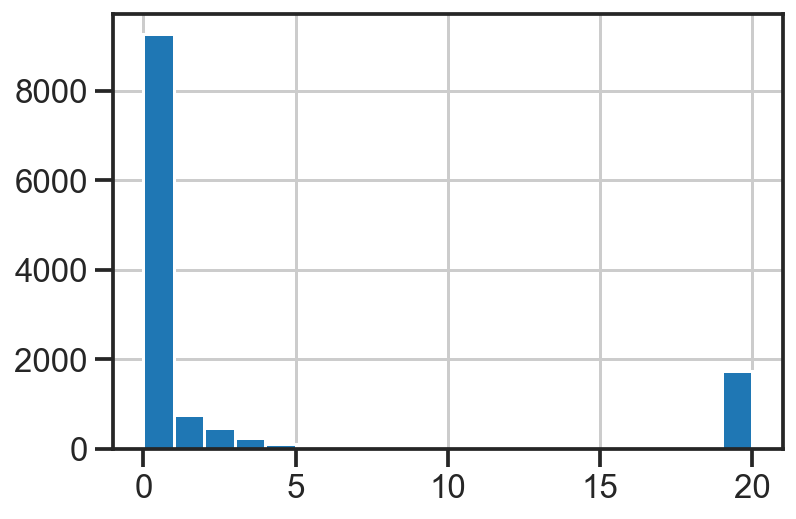

In [31]:
# qvalues have low resolution (1e-4)
_x = -np.log10(mat_qval).values
print(np.max(_x[np.isfinite(_x)]))

_x = -np.log10(mat_qval+1e-20).values

fig, ax = plt.subplots()
ax.hist(np.hstack(_x), bins=20)
plt.show()

# Todos:
- recal qvalues (1e-4 -> 1e-20)

# Improve visualization
- Cluster motifs and enhancer groups 
- Filter motifs: include motifs that are enriched (FDR<0.1) in at least 1 cell type

In [32]:
to_plot = -np.log10(mat_qval+1e-20)
# to_plot.index = [simplify_motif_name(name) for name in to_plot.index]

# filter motifs
fdr_th = 10 # 10^-10
cond = ((to_plot>fdr_th).sum(axis=1) > 0) # positive in at least 1 group
to_plot = to_plot[cond]
print(to_plot.shape)

mats = [
    to_plot.filter(regex=r'_all$', axis=1),    
    to_plot.filter(regex=r'_correlated$', axis=1),    
    to_plot.filter(regex=r'_linked$', axis=1),    
]


mat_labels = [
    'all', 'correlated', 'linked',
]

(250, 30)


In [33]:
# hierarchical 
pmat = mats[0]

Z = sch.linkage(pmat, method='ward', optimal_ordering=True)
g = sch.dendrogram(Z, no_plot=True)
motif_orders = np.array(g['ivl']).astype(int)

Z = sch.linkage(pmat.T, method='ward', optimal_ordering=True)
g = sch.dendrogram(Z, no_plot=True)
clst_orders = np.array(g['ivl']).astype(int)

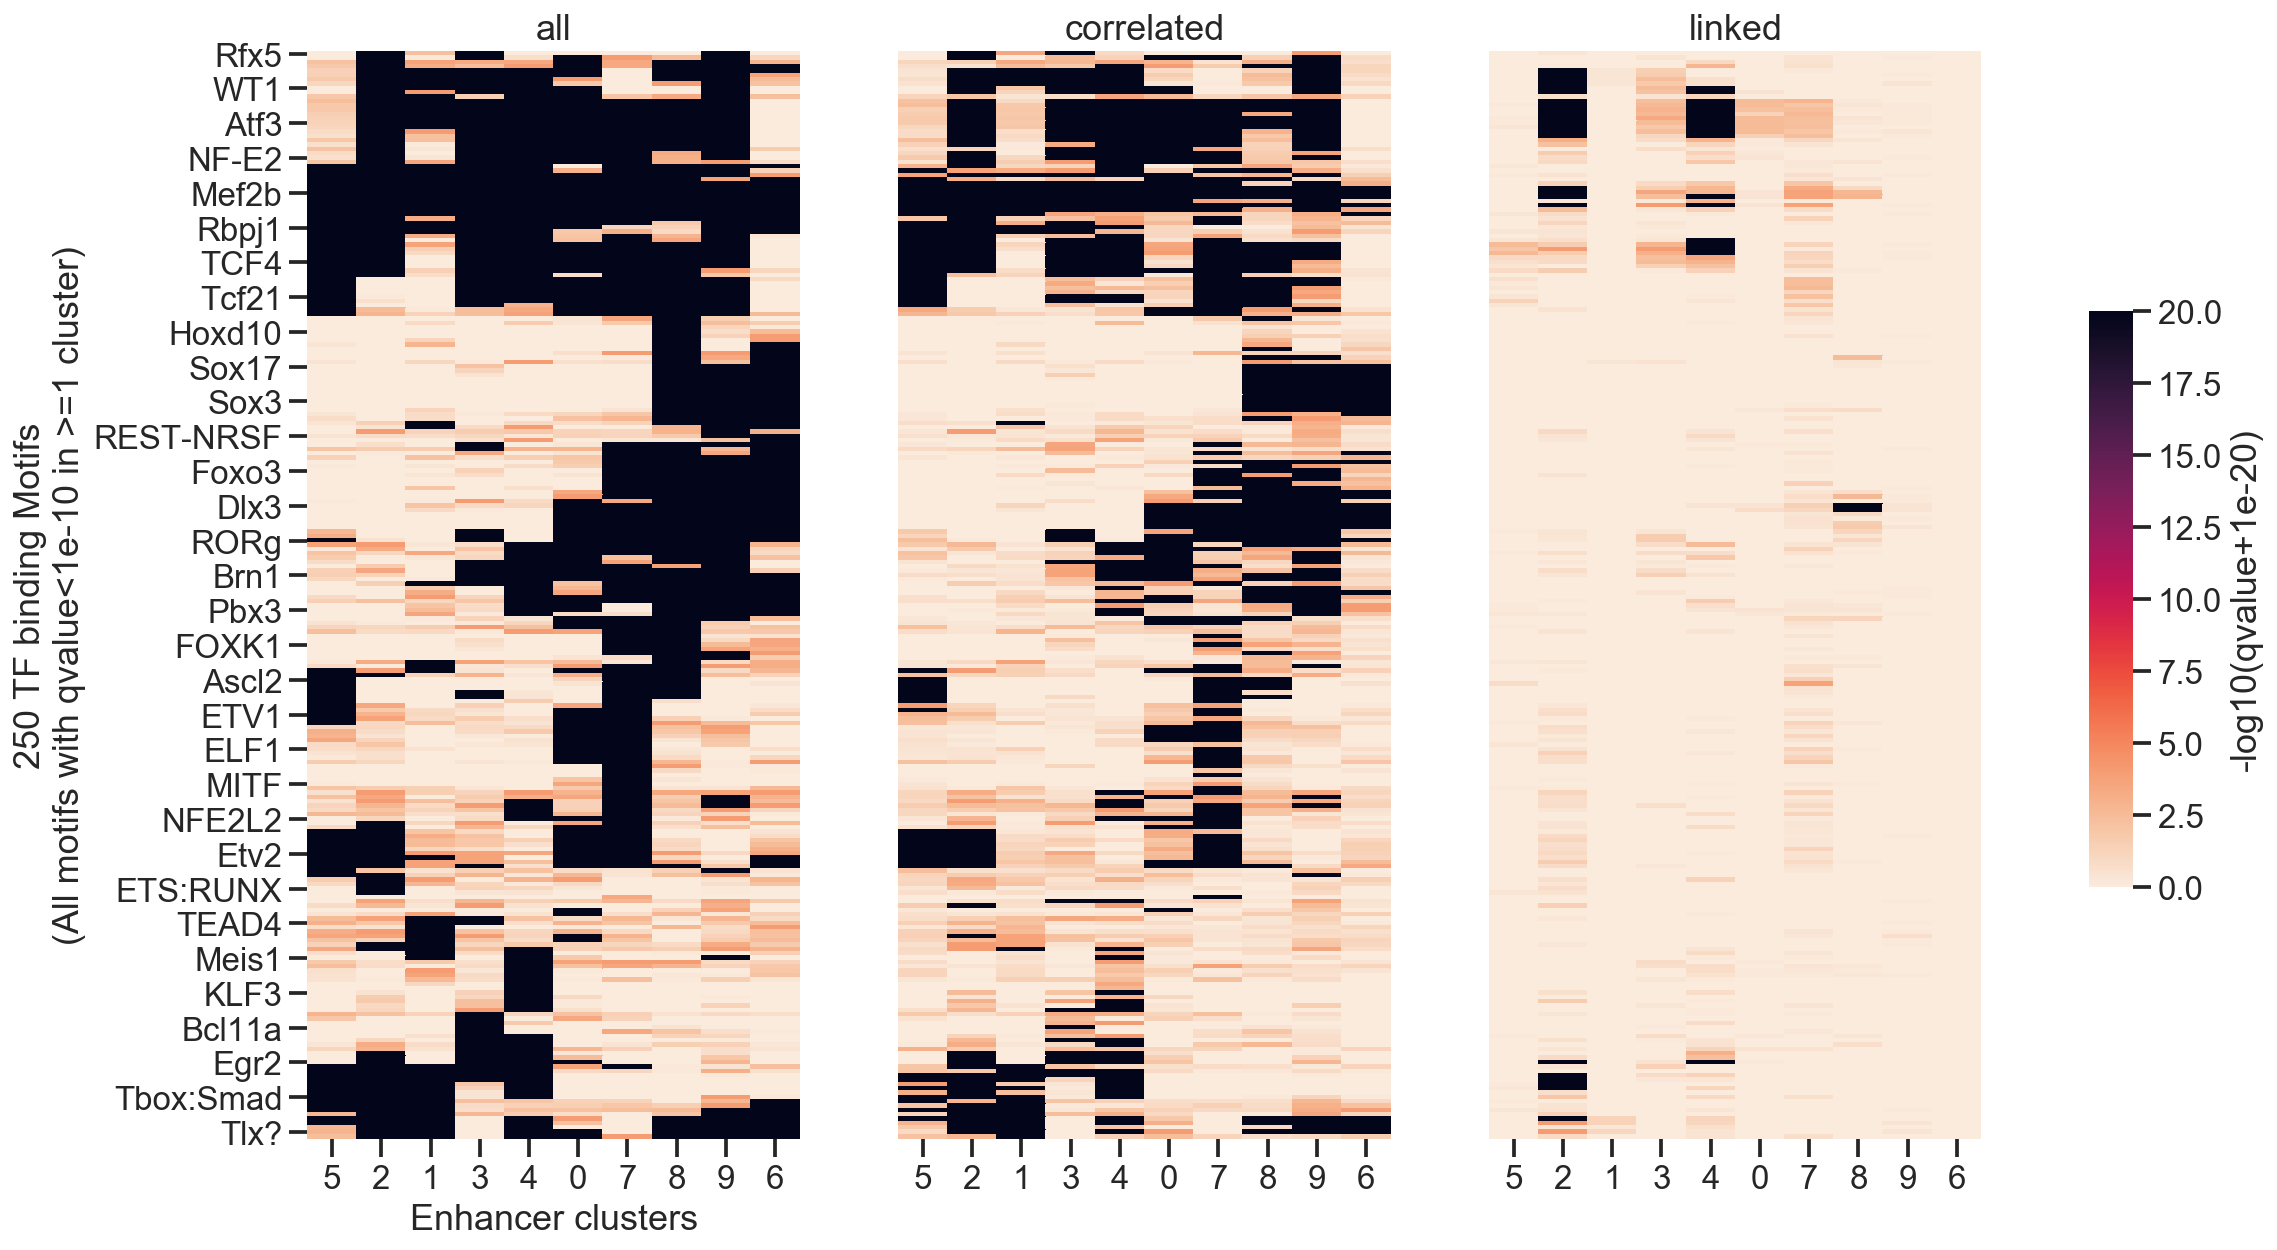

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(3*5, 1*10))
l, b, w, h = 0.95, 0.3, 0.02, 0.4
cbar_ax = fig.add_axes([l, b, w, h])

for i, (ax, mat, label) in enumerate(zip(axs, mats, mat_labels)): 
    if i == 0:
        yticklabels = 'auto'
        ylabel = "{} TF binding Motifs\n(All motifs with qvalue<1e-{} in >=1 cluster)".format(len(mat), fdr_th) 
        xlabel = "Enhancer clusters" 
        cbar = True
    else: 
        yticklabels = False
        ylabel = "" 
        xlabel = "" 
        cbar = False 
        
    mat.columns = [simplify_enhclst_name(col) for col in mat.columns]
    sns.heatmap(mat.iloc[motif_orders, clst_orders],  
                ax=ax, 
                yticklabels=yticklabels,
                cmap='rocket_r', vmin=0, vmax=20, 
                cbar=cbar, cbar_kws={'label': '-log10(qvalue+1e-20)', 'shrink': 0.5},
                cbar_ax=(None if i else cbar_ax), # only draw if i==0
               )
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(label)

plt.show()

In [35]:
to_plot2 = mat_fc 
to_plot2.index = [simplify_motif_name(name) for name in to_plot2.index]

# filter motifs
to_plot2 = to_plot2[cond]
print(to_plot2.shape)

mats2 = [
    to_plot2.filter(regex=r'_all$', axis=1),    
    to_plot2.filter(regex=r'_correlated$', axis=1),    
    to_plot2.filter(regex=r'_linked$', axis=1),    
]

(250, 30)


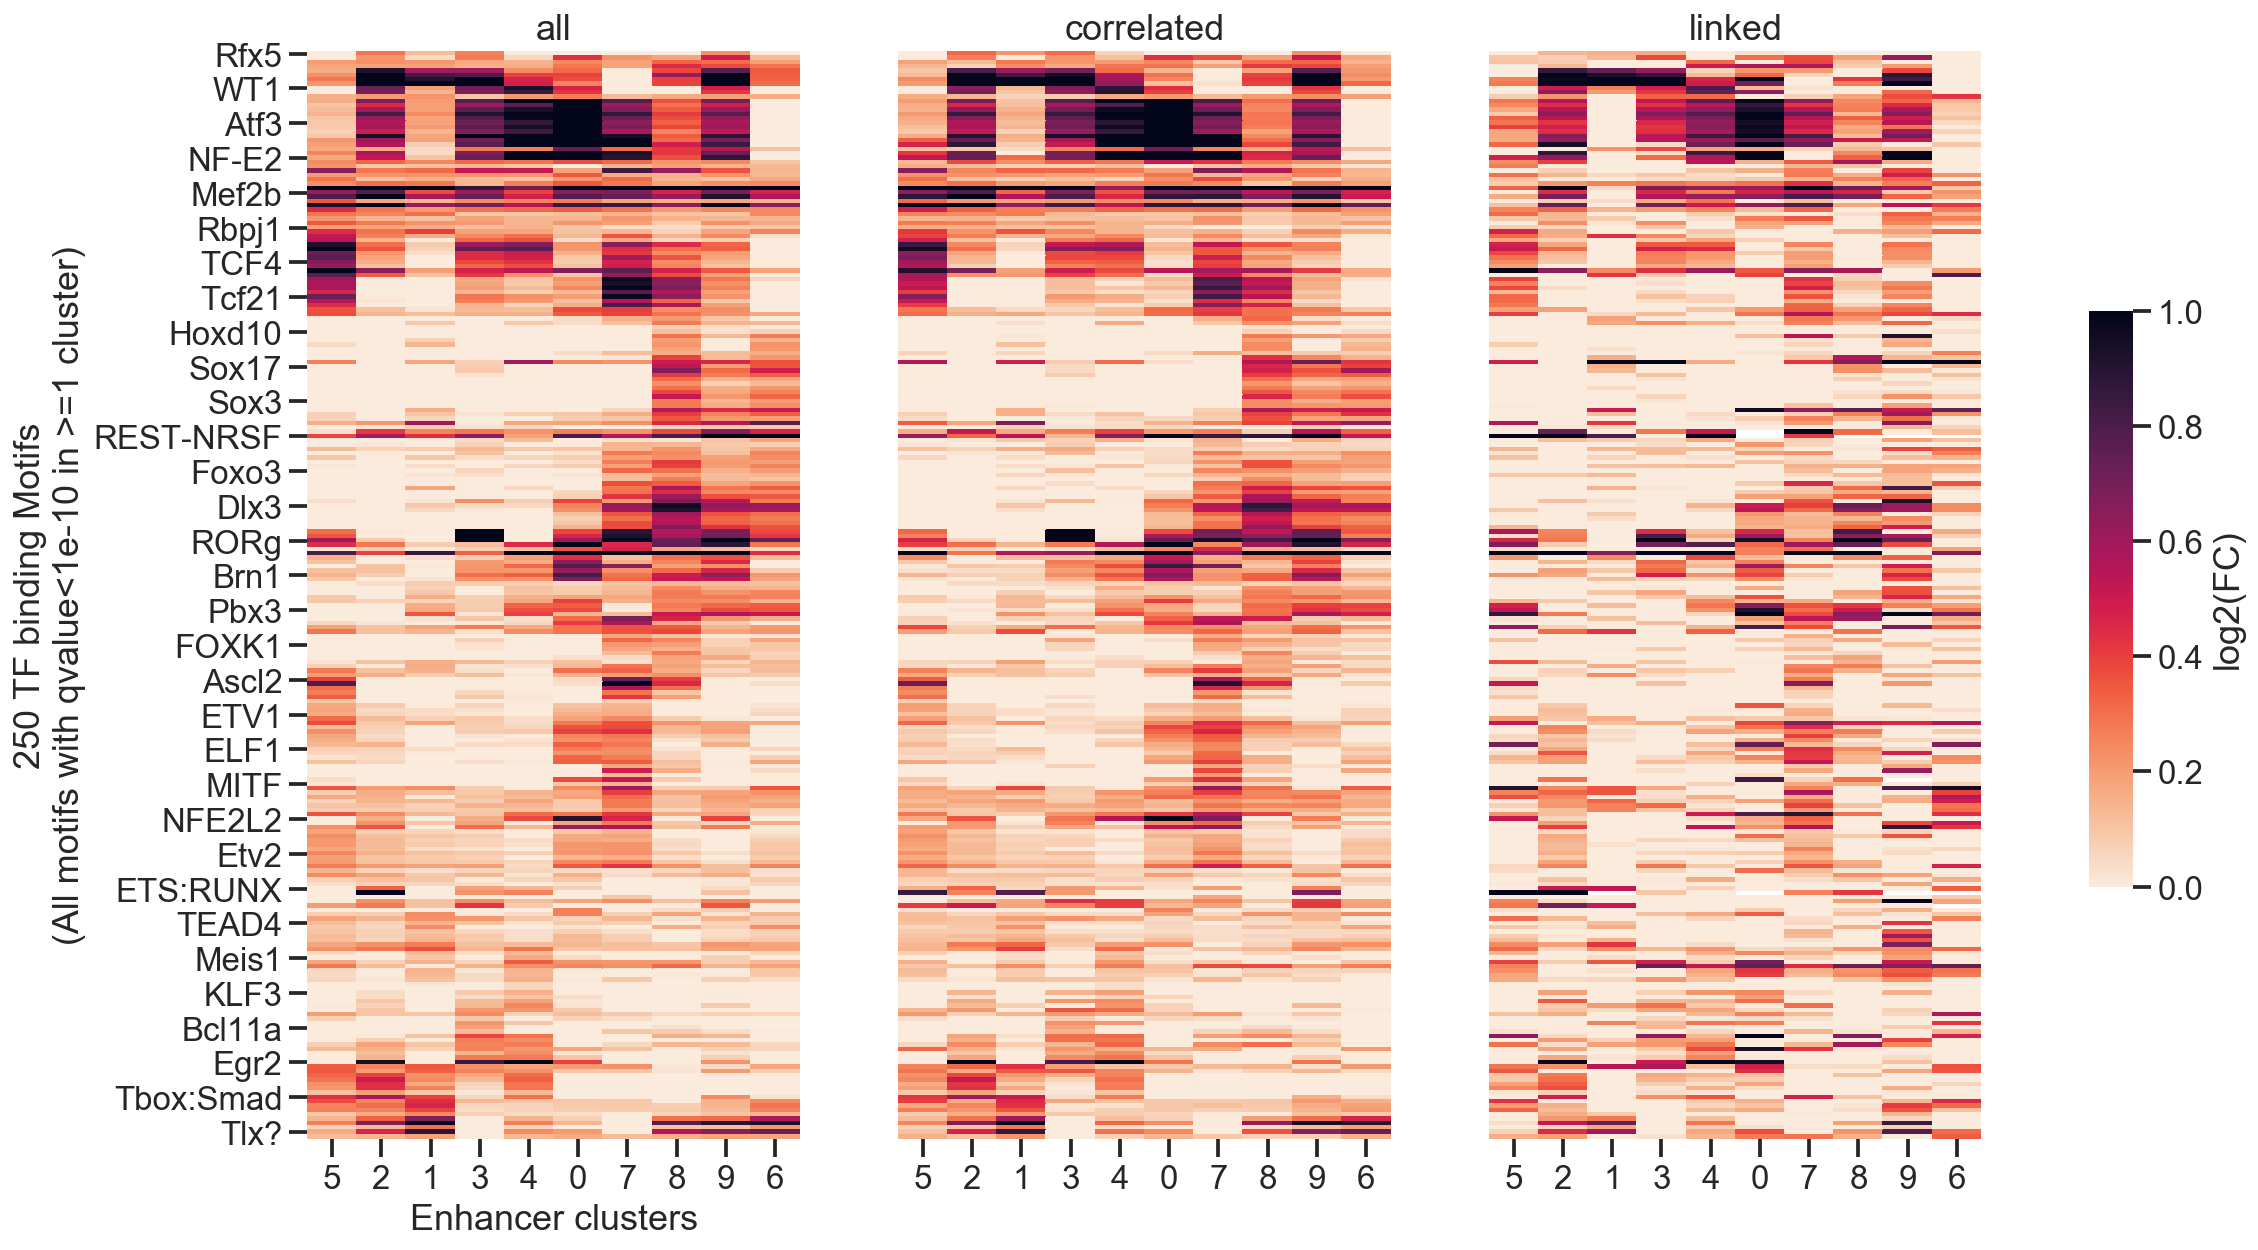

In [39]:
fig, axs = plt.subplots(1, 3, figsize=(3*5, 1*10))
l, b, w, h = 0.95, 0.3, 0.02, 0.4
cbar_ax = fig.add_axes([l, b, w, h])

for i, (ax, mat, label) in enumerate(zip(axs, mats2, mat_labels)): 
    if i == 0:
        yticklabels = 'auto'
        ylabel = "{} TF binding Motifs\n(All motifs with qvalue<1e-{} in >=1 cluster)".format(len(mat), fdr_th) 
        xlabel = "Enhancer clusters" 
        cbar = True
    else: 
        yticklabels = False
        ylabel = "" 
        xlabel = "" 
        cbar = False 
        
    mat.columns = [simplify_enhclst_name(col) for col in mat.columns]
    sns.heatmap(mat.iloc[motif_orders, clst_orders],  
                ax=ax, 
                yticklabels=yticklabels,
                cmap='rocket_r', 
                vmin=0, 
                vmax=1, 
                cbar=cbar, cbar_kws={'label': 'log2(FC)', 'shrink': 0.5},
                cbar_ax=(None if i else cbar_ax), # only draw if i==0
               )
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(label)

plt.show()

# Top enriched for each cluster

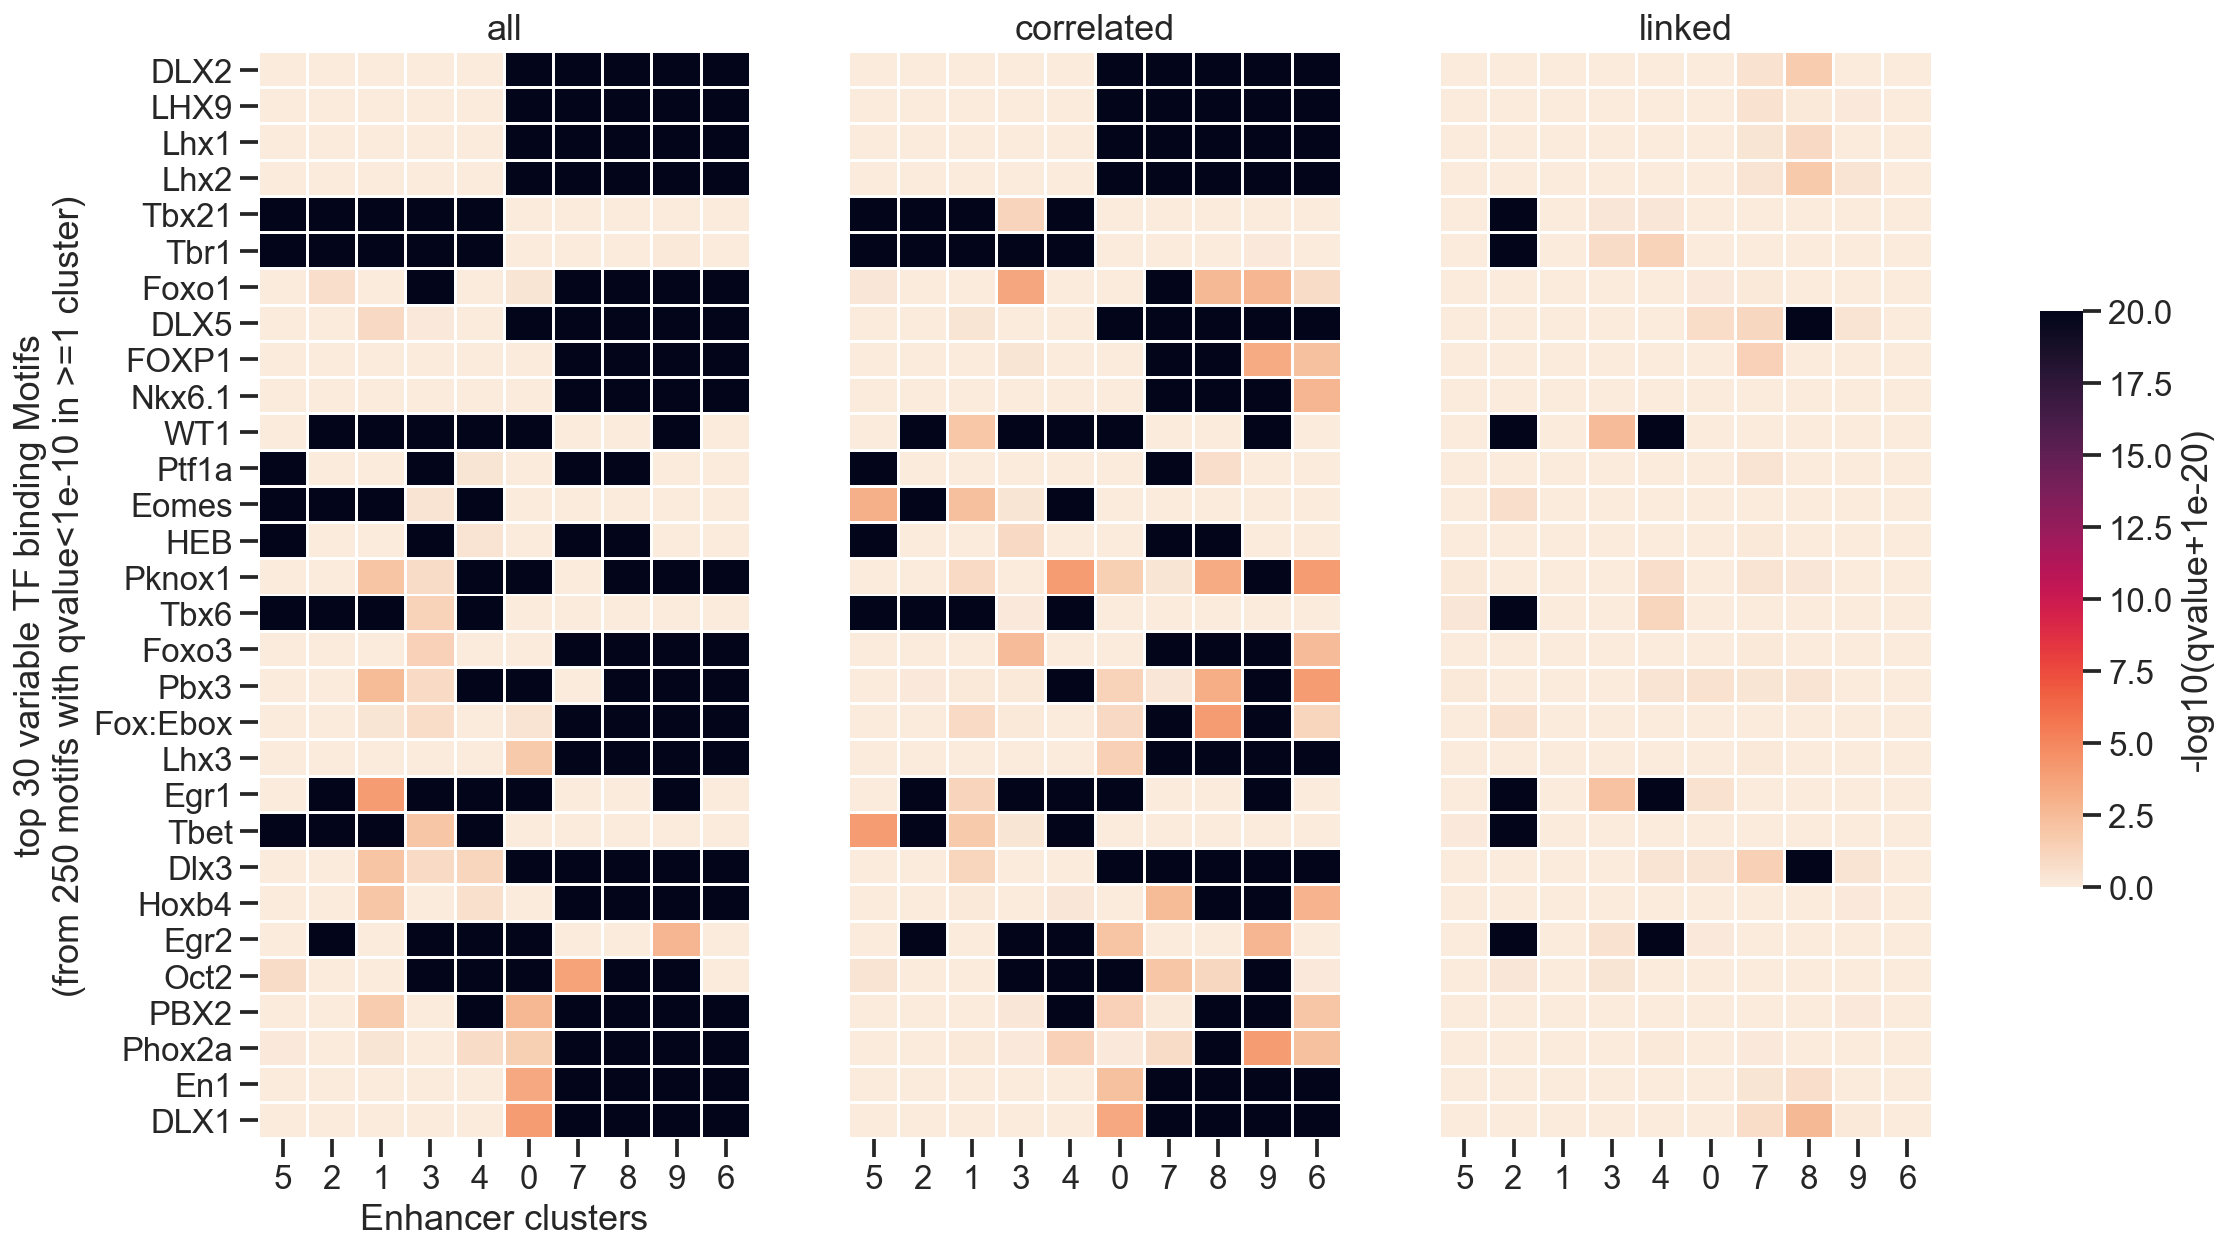

In [12]:
ntop = 30
top_variable = pmat.std(axis=1).nlargest(ntop).index

fig, axs = plt.subplots(1, 3, figsize=(3*5, 1*10))
l, b, w, h = 0.95, 0.3, 0.02, 0.4
cbar_ax = fig.add_axes([l, b, w, h])

for i, (ax, mat, label) in enumerate(zip(axs, mats, mat_labels)): 
    if i == 0:
        yticklabels = 'auto'
        ylabel = "top {} variable TF binding Motifs\n(from {} motifs with qvalue<1e-{} in >=1 cluster)".format(ntop, len(mat), fdr_th) 
        xlabel = "Enhancer clusters" 
        cbar = True
    else: 
        yticklabels = False
        ylabel = "" 
        xlabel = "" 
        cbar = False 
        
    mat.columns = [simplify_enhclst_name(col) for col in mat.columns]
    sns.heatmap(mat.iloc[:,clst_orders].reindex(top_variable),  
                ax=ax, 
                yticklabels=yticklabels,
                cmap='rocket_r', vmin=0, vmax=20, 
                cbar=cbar, cbar_kws={'label': '-log10(qvalue+1e-20)', 'shrink': 0.5},
                cbar_ax=(None if i else cbar_ax), # only draw if i==0
                linewidth=1,
               )
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(label)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.show()

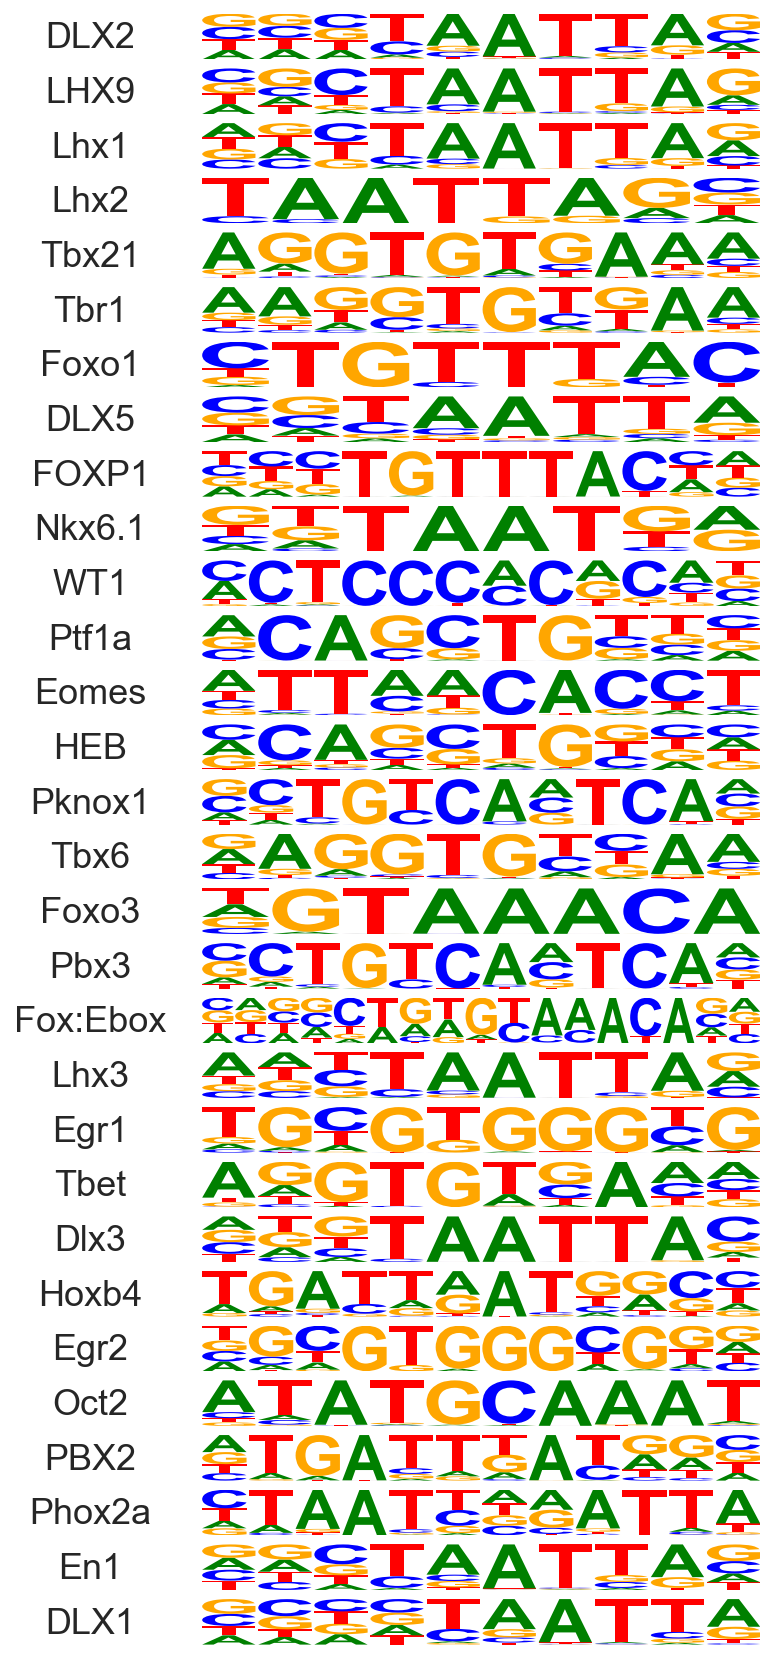

In [13]:
fig, axs = plt.subplots(ntop, 1, figsize=(5, 0.5*ntop))
for ax, motif in zip(axs, top_variable.values):
    logomaker.Logo(motif_pwms[motif], 
                   show_spines=False,
                   ax=ax,
                   )
    ax.set_ylabel(motif, rotation=0)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.yaxis.set_label_coords(-0.2, 0.1,)
    
plt.show()

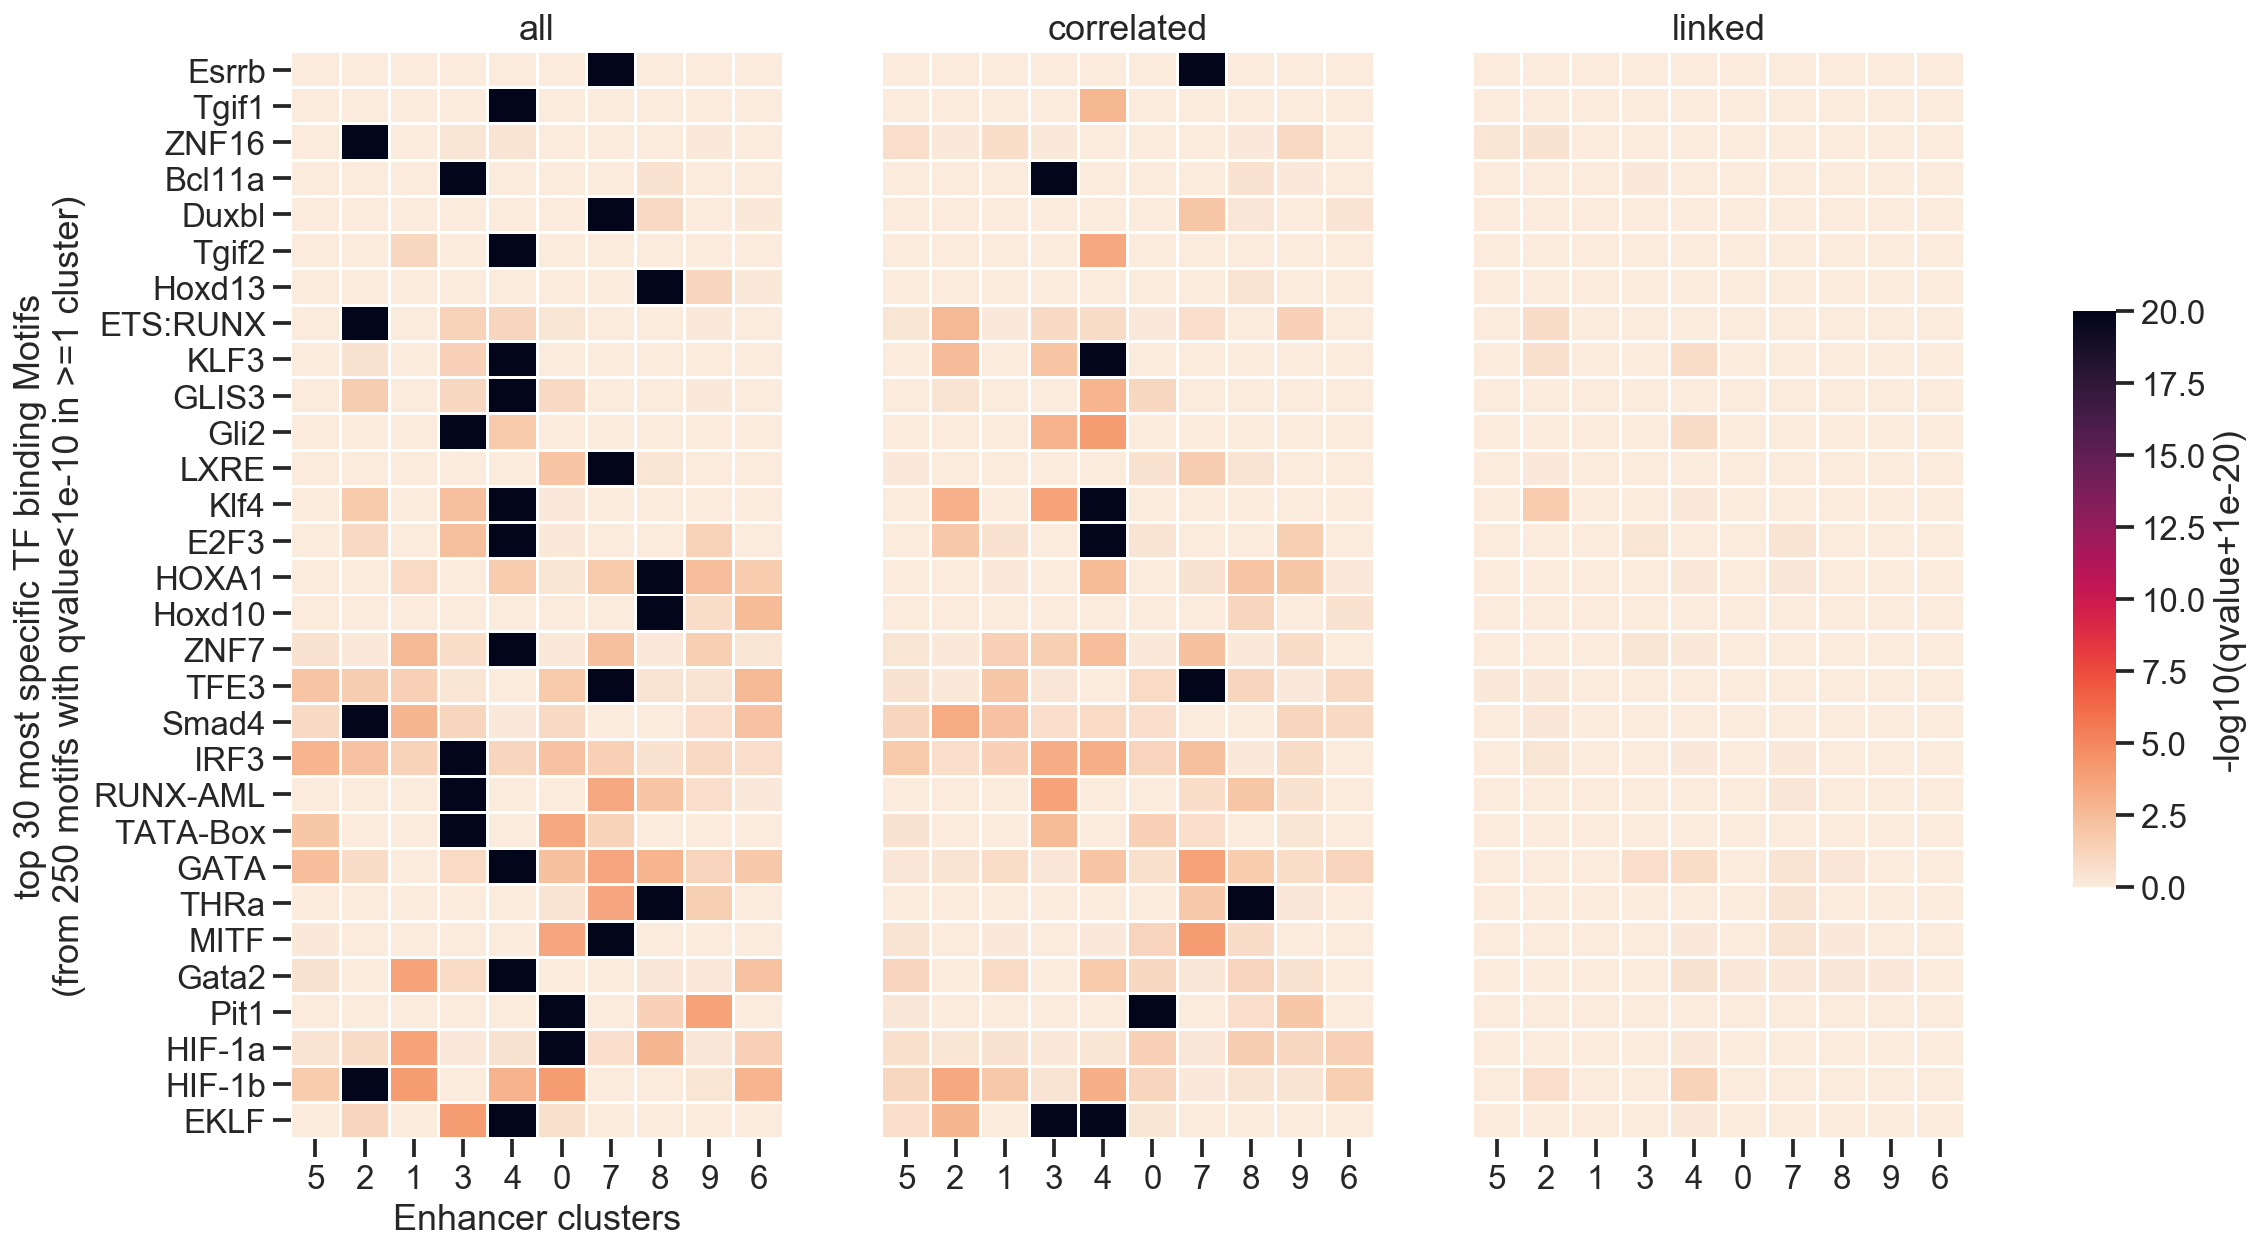

In [14]:
ntop = 30

# new order
sorted_mat = np.sort(pmat.values, axis=1)
specific_motif_order = np.argsort(sorted_mat[:,-1]-sorted_mat[:,-2])[::-1][:ntop]

fig, axs = plt.subplots(1, 3, figsize=(3*5, 1*10))
l, b, w, h = 0.95, 0.3, 0.02, 0.4
cbar_ax = fig.add_axes([l, b, w, h])

for i, (ax, mat, label) in enumerate(zip(axs, mats, mat_labels)): 
    if i == 0:
        yticklabels = 'auto'
        ylabel = "top {} most specific TF binding Motifs\n(from {} motifs with qvalue<1e-{} in >=1 cluster)".format(ntop, len(mat), fdr_th) 
        xlabel = "Enhancer clusters" 
        cbar = True
    else: 
        yticklabels = False
        ylabel = "" 
        xlabel = "" 
        cbar = False 
        
    mat.columns = [simplify_enhclst_name(col) for col in mat.columns]
    sns.heatmap(mat.iloc[specific_motif_order, clst_orders],  
                ax=ax, 
                yticklabels=yticklabels,
                cmap='rocket_r', vmin=0, vmax=20, 
                cbar=cbar, cbar_kws={'label': '-log10(qvalue+1e-20)', 'shrink': 0.5},
                cbar_ax=(None if i else cbar_ax), # only draw if i==0
                linewidth=1,
               )
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(label)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.show()

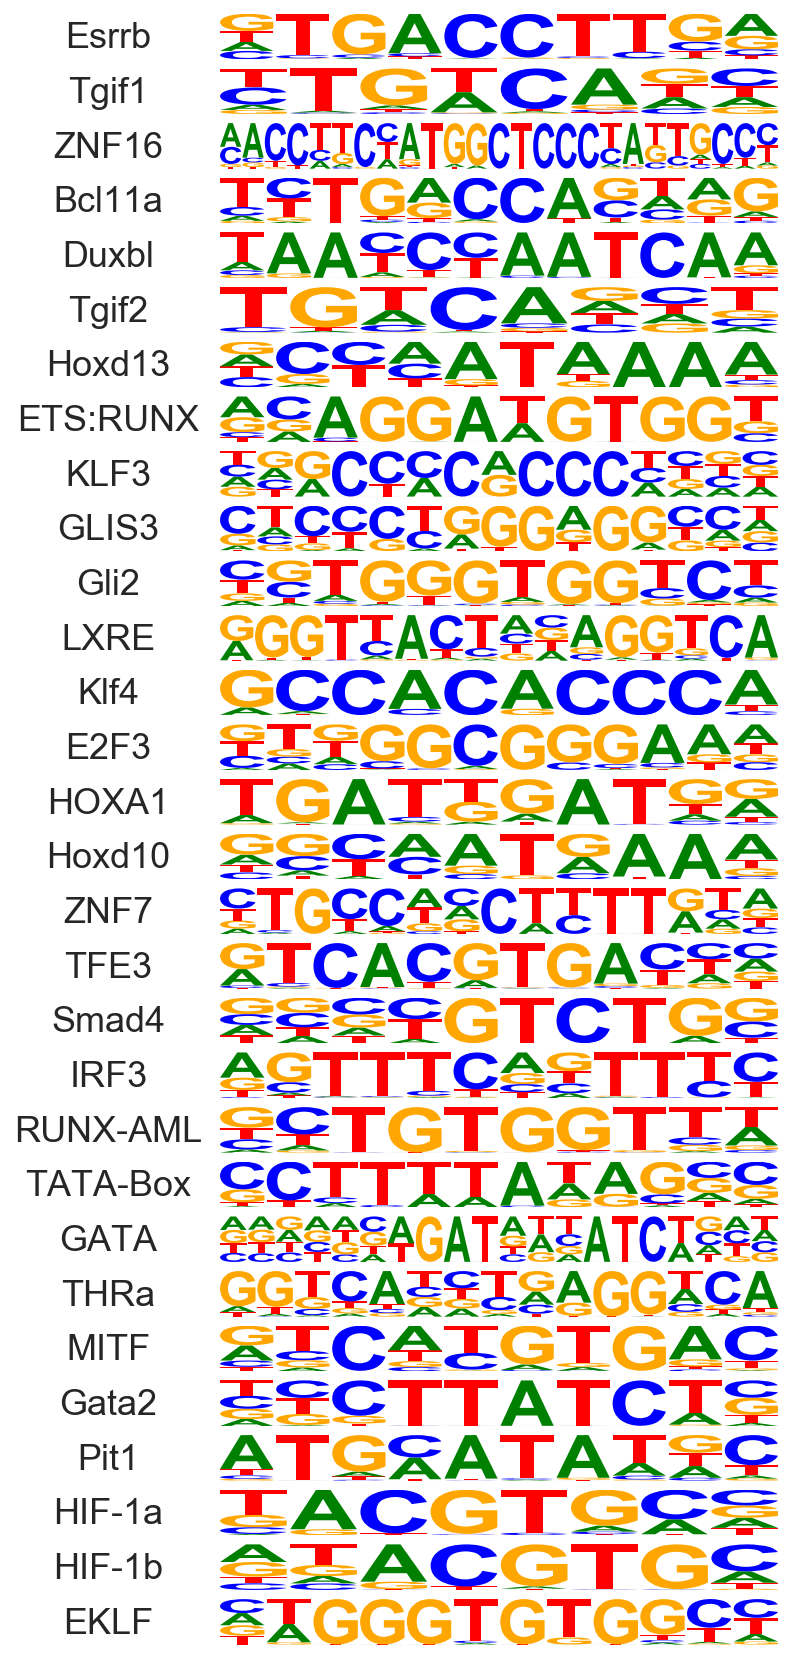

In [15]:
fig, axs = plt.subplots(ntop, 1, figsize=(5, 0.5*ntop))
for ax, motif in zip(axs, pmat.iloc[specific_motif_order].index.values):
    logomaker.Logo(motif_pwms[motif], 
                   show_spines=False,
                   ax=ax,
                   )
    ax.set_ylabel(motif, rotation=0)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.yaxis.set_label_coords(-0.2, 0.1,)
    
plt.show()